**<분석 내용>**

**1.주요실적**
  + [x] A. 누적 방문자 수 : 
  + [x] B. 회원유발 매출액 : 
  + [x] C. 프로모션 ROAS : 

**2.회원 방문 분석**
  + [x] A.월별 누적방문 회원수(당해년도)
  + [x] B.누적방문 횟수 : 1~6+ 기준
  + [x] C.서비스 이용 인원 : venn
  + [x] D.Cohort 분석 : 월별 방문기준
  + [x] E.관계사별 교차방문 현황
  + [x] F.RFM 분석

3.회원 매출 분석 : 월별 서비스별 기여매출 금액


4.프로모션 결과 : 2022년도


---------------------
+ [x] 1.주요실적
+ [x] 2.월별 서비스별 유발 매출
+ [x] 3.프로모션 결과 : table
+ [ ] 4.매장별 유발 매출(서비스 무관)
  

In [1]:
###############
# 1. import
#####


import warnings
warnings.filterwarnings("ignore")

# DB접속
import os
from os import listdir
import cx_Oracle as oci
import numpy as np
import pandas as pd

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib_venn import venn3
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)


# RFM 계산
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
from lifetimes.utils import summary_data_from_transaction_data


# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta


# 내용공유(e-mail, 회사) 
from jinja2 import Template
import win32com.client
from glob import glob
import io
import base64
from PIL import Image


In [2]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

### 1.주요실적

In [3]:
# query run
query1 = '''
    /* 주요실적  */
    with date_table as (
        SELECT FIRST_DAY + LEVEL - 1 as REG_DTM
        FROM    (SELECT TRUNC(SYSDATE, 'YYYY') FIRST_DAY FROM DUAL)
        CONNECT BY FIRST_DAY + LEVEL - 1 <= TRUNC(LAST_DAY(SYSDATE))
        )
    select A.REG_DTM, B.banner_cnt, C.App_Login_CNT, D.BRAND_COME
    from date_table A

        /* (Acquisition) Maeil Do 이벤트 베너 유입자 수 */
        left join (select reg_dtm, count(*) as banner_cnt
        from ( select distinct G.client_ip, G.unfy_mmb_no, G.evnt_no, trunc(G.reg_dtm) as reg_dtm, T.evnt_tite
        from tch_evnt_click_log g, tch_evnt T
        where G.evnt_no = T.evnt_no
        and (T.evnt_tite like '%크리스탈%' or T.evnt_tite like '%시즌메뉴%' or T.evnt_tite like '%기프트카드%')
        ) group by reg_dtm) B
        on A.reg_dtm = B.reg_dtm

        /* (Activation) Maeil Do App 로그인 인원 */
        left join (select trunc(A.reg_dtm) as reg_dtm, count(*) as App_Login_CNT
        from tm_lgn_hist A, tm_mmb_info I
        where I.unfy_mmb_no = A.unfy_mmb_no
        and lgn_coopco_cd = 7000 and lgn_path in ('371', '372')
        and to_char(A.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        group by trunc(A.reg_dtm)) C
        on A.reg_dtm = C.reg_dtm

        /* (Revenue) Maeil Do 기준, 매장방문자 수 */
        left join (
        select REG_DTM, count(*) as BRAND_COME
        from ( select unfy_mmb_no, REG_DTM
        , LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun ASC) OVER(PARTITION BY unfy_mmb_no, REG_DM) AS names
        from (
            select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, 'point_acml' AS gubun
            from TP_TRSC_PTCL
            where COOPCO_CD in('7050','7060' ) and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM,  'point_use' AS gubun
            from TP_TRSC_PTCL
            where  COOPCO_CD in ('7050','7060' ) and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select distinct  A.unfy_mmb_no, trunc(A.reg_dtm) as REG_DTM, to_char(A.reg_dtm, 'YYYY-MM') as REG_DM,  'coupon' AS gubun
            from mmbship.TPM_CPN_ISSU A, TPM_CPN B
            where B.use_coopco_cd in ('7050','7060' ) and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM,  'gift_card' AS gubun
            from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
            where U.coopco_cd in('7050','7060') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
            ) 
        ) group by REG_DTM ) D 
        on A.reg_dtm = D.reg_dtm

        /* (Retention) Maeil Do 기준, 매장 재방문자 수 */

    order by A.REG_DTM asc
    '''
df1 = pd.read_sql(query1, con = conn )

In [2]:
# import
from google.cloud import bigquery
import os 


###############
# 저장된 자료 불러오기
#####

# 접속 정보 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./boxwood-******************.json"
client = bigquery.Client()

#########
# 자료1 : 키워드 수집현황
###
sql1 = """
        select STORE_NAME, DATE as REG_DTM
        , sum(REVIEW_CNT) as REVIEW_CNT
        , sum(BLOG_CNT)   as BLOG_CNT
        , round(sum(REVIEW_SCORE*REVIEW_CNT) / sum(REVIEW_CNT),2) as REVIEW_SCORE_AVG
        from (
          SELECT (case when STORE_NAME like '크리스탈%' then '크리스탈 제이드' else '더 키친 일뽀르노' end) as STORE_NAME
          , FORMAT_DATETIME('%Y-%m-%d', CAST( TIMESTAMP_ADD(REG_DTM, INTERVAL -1 DAY) AS DATETIME)) as DATE
          , REVIEW_CNT
          , BLOG_CNT
          , REVIEW_SCORE
          FROM `boxwood-chassis-356100.review.dinning_review_summary` 
          where FORMAT_DATETIME('%Y', CAST(REG_DTM AS DATETIME)) =  FORMAT_DATETIME('%Y', current_date())
          )
        group by STORE_NAME, DATE
      """
df_temp = client.query(sql1).to_dataframe()


In [3]:
sql1 = """
          SELECT *
          FROM `boxwood-chassis-356100.review.dinning_review_summary` 
          where FORMAT_DATETIME('%Y', CAST(REG_DTM AS DATETIME)) =  FORMAT_DATETIME('%Y', current_date())
      """
df_temp = client.query(sql1).to_dataframe()


In [4]:
df_temp = df_temp[df_temp['STORE_NAME']=='크리스탈 제이드']

In [5]:
df_temp

,STORE_CODE,STORE_NAME,REVIEW_SCORE,REVIEW_CNT,BLOG_CNT,REG_DTM


In [7]:
# df_temp = df_temp.groupby('REG_DTM')['REVIEW_CNT', 'BLOG_CNT' ].sum().reset_index()

In [8]:
df1.head(2)

,REG_DTM,BANNER_CNT,APP_LOGIN_CNT,BRAND_COME
0,2022-01-01,112.0,1560,3.0
1,2022-01-02,117.0,1347,17.0


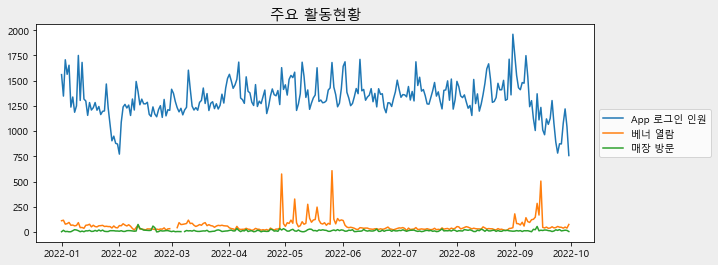

In [18]:
mpl.rc('figure', figsize=(10, 4), facecolor='#eeeeee')

plt.plot(df1.REG_DTM, df1.APP_LOGIN_CNT, label='App 로그인 인원')
plt.plot(df1.REG_DTM, df1.BANNER_CNT,    label='베너 열람')
plt.plot(df1.REG_DTM, df1.BRAND_COME,    label='매장 방문')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('주요 활동현황', size = 'x-large')

plt.show()

In [10]:
df1_monthly = df1.groupby(pd.Grouper(key='REG_DTM', axis=0, freq='M')).sum().reset_index()
df1_monthly['REG_DTM'] + np.timedelta64(1, 'D')

0   2022-02-01
1   2022-03-01
2   2022-04-01
3   2022-05-01
4   2022-06-01
5   2022-07-01
6   2022-08-01
7   2022-09-01
8   2022-10-01
Name: REG_DTM, dtype: datetime64[ns]

In [46]:
df1_monthly = df1.groupby(pd.Grouper(key='REG_DTM', axis=0, freq='M')).sum().reset_index()

df1_monthly['YYYYMM']  = (df1_monthly['REG_DTM'] + np.timedelta64(0, 'D')).dt.strftime('%Y.%m')
df1_monthly['REG_DTM'] = df1_monthly['REG_DTM'].dt.strftime('%Y-%m-%d')

In [47]:
df1_monthly = pd.merge(df1_monthly, df_temp, on ='REG_DTM', how='left')

In [48]:
df1_monthly = df1_monthly[['YYYYMM','APP_LOGIN_CNT','BANNER_CNT','BRAND_COME', 'REVIEW_CNT','BLOG_CNT' ]]

In [49]:
df1_monthly['delta'] = df1_monthly.REVIEW_CNT - df1_monthly.REVIEW_CNT.shift()

In [60]:
df1_monthly

,YYYYMM,APP_LOGIN_CNT,BANNER_CNT,BRAND_COME,REVIEW_CNT,BLOG_CNT,delta
0,2022.01,39739,1998.0,320.0,NaN,NaN,NaN
1,2022.02,34168,1121.0,506.0,NaN,NaN,NaN
2,2022.03,40251,1985.0,278.0,NaN,NaN,NaN
3,2022.04,41534,1454.0,429.0,NaN,NaN,NaN
4,2022.05,43338,4020.0,482.0,NaN,NaN,NaN
5,2022.06,41142,1151.0,390.0,NaN,NaN,NaN
6,2022.07,42749,966.0,412.0,NaN,NaN,NaN
7,2022.08,43509,1072.0,426.0,8356.0,3737.0,NaN
8,2022.09,35975,2964.0,457.0,NaN,NaN,NaN


In [62]:
# df1_monthly['REVIEW_CNT'][-1] = 8556
# df1_monthly.insert(loc = -1, column = 'REVIEW_CNT', value = 8556)

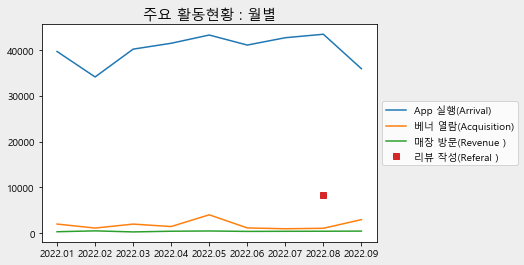

In [15]:
mpl.rc('figure', figsize=(6, 4), facecolor='#eeeeee')
plt.plot(df1_monthly.YYYYMM, df1_monthly.APP_LOGIN_CNT, label='App 실행(Arrival)')
plt.plot(df1_monthly.YYYYMM, df1_monthly.BANNER_CNT, label='베너 열람(Acquisition)')
plt.plot(df1_monthly.YYYYMM, df1_monthly.BRAND_COME, label='매장 방문(Revenue )')
plt.plot(df1_monthly.YYYYMM, df1_monthly.REVIEW_CNT, 's', label='리뷰 작성(Referal )')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('주요 활동현황 : 월별', size = 'x-large')

plt.show()

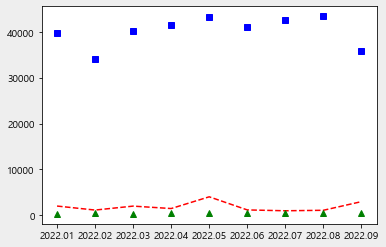

In [16]:
plt.plot(df1_monthly.YYYYMM, df1_monthly.BANNER_CNT, 'r--',
         df1_monthly.YYYYMM, df1_monthly.APP_LOGIN_CNT, 'bs',
         df1_monthly.YYYYMM, df1_monthly.BRAND_COME, 'g^')
plt.show()

In [17]:
df1_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 0 to 8
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YYYYMM         9 non-null      object 
 1   APP_LOGIN_CNT  9 non-null      int64  
 2   BANNER_CNT     9 non-null      float64
 3   BRAND_COME     9 non-null      float64
 4   REVIEW_CNT     1 non-null      float64
 5   BLOG_CNT       1 non-null      float64
dtypes: float64(4), int64(1), object(1)
memory usage: 504.0+ bytes


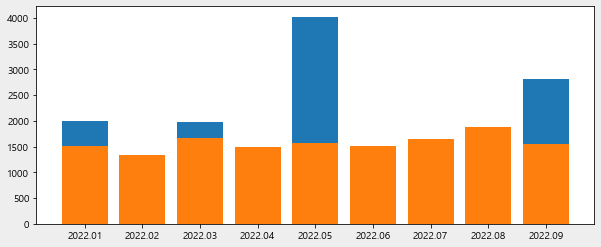

In [25]:
plt.bar(df1_monthly.YYYYMM, df1_monthly.BANNER_CNT)
plt.bar(df1_monthly.YYYYMM, df1_monthly.APP_LOGIN_CNT )
plt.show()

### 2.회원 방문 분석

In [82]:
###############
# A. 월별 누적방문 회원수(당해년도)
#####

# query run
query1 = '''
    select REG_YY, REG_MM, sum(방문자수) over (order by REG_MM) as CNT 
    from (
        select REG_YY, REG_MM, count(*) as 방문자수
        from (
            select unfy_mmb_no, REG_YY, min(REG_MM) as REG_MM 
            from (
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where COOPCO_CD in('7050') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
                group by unfy_mmb_no
                union all
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
                group by unfy_mmb_no
                union all
                select A.unfy_mmb_no, to_char(min(A.upd_dtm), 'YYYY') as REG_YY, to_char(min(A.upd_dtm), 'MM') as REG_MM
                from mmbship.TPM_CPN_ISSU A, TPM_CPN B
                where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
                group by A.unfy_mmb_no
                union all
                select M.unfy_mmb_no, to_char(min(U.REG_DT), 'YYYY') as REG_YY, to_char(min(U.REG_DT), 'MM') as REG_MM
                from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
                where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
                group by M.unfy_mmb_no
                ) group by unfy_mmb_no, REG_YY
            ) group by REG_YY, REG_MM
        )
    '''
df1_A = pd.read_sql(query1, con = conn )
df1_A['REG_MM'] = df1_A['REG_MM'] + '월'

query2 = '''
    select REG_YY, REG_MM, sum(방문자수) over (order by REG_MM) as CNT 
    from (
        select REG_YY, REG_MM, count(*) as 방문자수
        from (
            select unfy_mmb_no, REG_YY, min(REG_MM) as REG_MM 
            from (
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where COOPCO_CD in('7050') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate-365, 'YYYY')
                group by unfy_mmb_no
                union all
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate-365, 'YYYY')
                group by unfy_mmb_no
                union all
                select A.unfy_mmb_no, to_char(min(A.upd_dtm), 'YYYY') as REG_YY, to_char(min(A.upd_dtm), 'MM') as REG_MM
                from mmbship.TPM_CPN_ISSU A, TPM_CPN B
                where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate-365, 'YYYY')
                group by A.unfy_mmb_no
                union all
                select M.unfy_mmb_no, to_char(min(U.REG_DT), 'YYYY') as REG_YY, to_char(min(U.REG_DT), 'MM') as REG_MM
                from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
                where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate-365, 'YYYY') and U.use_amt > 0
                group by M.unfy_mmb_no
                ) group by unfy_mmb_no, REG_YY
            ) group by REG_YY, REG_MM
        )
    '''
df1_B = pd.read_sql(query2, con = conn )
df1_B['REG_MM'] = df1_B['REG_MM'] + '월'

query3 = '''
    select REG_YY, REG_MM, sum(방문자수) over (order by REG_MM) as CNT 
    from (
        select REG_YY, REG_MM, count(*) as 방문자수
        from (
            select unfy_mmb_no, REG_YY, min(REG_MM) as REG_MM 
            from (
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where COOPCO_CD in('7050') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate-730, 'YYYY')
                group by unfy_mmb_no
                union all
                select unfy_mmb_no, to_char(min(reg_dtm), 'YYYY') as REG_YY, to_char(min(reg_dtm), 'MM') as REG_MM
                from TP_TRSC_PTCL
                where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate-730, 'YYYY')
                group by unfy_mmb_no
                union all
                select A.unfy_mmb_no, to_char(min(A.upd_dtm), 'YYYY') as REG_YY, to_char(min(A.upd_dtm), 'MM') as REG_MM
                from mmbship.TPM_CPN_ISSU A, TPM_CPN B
                where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate-730, 'YYYY')
                group by A.unfy_mmb_no
                union all
                select M.unfy_mmb_no, to_char(min(U.REG_DT), 'YYYY') as REG_YY, to_char(min(U.REG_DT), 'MM') as REG_MM
                from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
                where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate-730, 'YYYY') and U.use_amt > 0
                group by M.unfy_mmb_no
                ) group by unfy_mmb_no, REG_YY
            ) group by REG_YY, REG_MM
        )
'''
df1_C = pd.read_sql(query3, con = conn )
df1_C['REG_MM'] = df1_C['REG_MM'] + '월'

In [83]:
df1 = pd.concat([df1_A, df1_C, df1_B], ignore_index=True)
report_01 = pd.pivot_table(df1, values='CNT', index=['REG_MM'],columns=['REG_YY'],  aggfunc='sum')
pd.options.display.float_format = '{:0,.0f}'.format

In [84]:
report_01

REG_YY,2020,2021,2022
REG_MM,,,
01월,107,144,175
02월,174,289,372
03월,201,381,436
04월,277,474,521
05월,383,553,634
06월,507,621,733
07월,654,685,832
08월,727,729,909
09월,925,777,969


In [178]:
###############
# B. 누적방문 횟수 : 1~6+ 기준
#####

# 쿼리비교 : 일별 이용 기준
# query1B ='''
# select unfy_mmb_no, REG_DTM, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun) AS service
# from (
#     select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, 'point_acml' AS gubun
#     from TP_TRSC_PTCL
#     where COOPCO_CD in('7050') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
#     union all
#     select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, 'point_use' AS gubun
#     from TP_TRSC_PTCL
#     where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
#     union all
#     select distinct  A.unfy_mmb_no, trunc(A.upd_dtm) as REG_DTM, 'coupon' AS gubun
#     from mmbship.TPM_CPN_ISSU A, TPM_CPN B
#     where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
#     union all
#     select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, 'gift_card' AS gubun
#     from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
#     where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
# )
# GROUP BY unfy_mmb_no, REG_DTM
# '''
# df1_B =  pd.read_sql(query1B, con = conn )
# df1_B['VISIT_COUNT'] = df1_B.groupby('UNFY_MMB_NO').cumcount(ascending=True)+1
# df1_B['CNT'] = 1

In [85]:
###############
# B. 누적방문 횟수 : 1~6+ 기준
#####

# 쿼리비교 : 월별 이용 기준
query4 ='''
select unfy_mmb_no, REG_DM, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun) AS service
from (
    select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, 'point_acml' AS gubun
    from TP_TRSC_PTCL
    where COOPCO_CD in('7050') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM,  'point_use' AS gubun
    from TP_TRSC_PTCL
    where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select distinct  A.unfy_mmb_no, trunc(A.upd_dtm) as REG_DTM, to_char(A.upd_dtm, 'YYYY-MM') as REG_DM,  'coupon' AS gubun
    from mmbship.TPM_CPN_ISSU A, TPM_CPN B
    where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM,  'gift_card' AS gubun
    from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
    where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
)
GROUP BY unfy_mmb_no, REG_DM
'''
df1_D =  pd.read_sql(query4, con = conn )
df1_D['VISIT_COUNT'] = df1_D.groupby('UNFY_MMB_NO').cumcount(ascending=True)+1
df1_D['CNT'] = 1
# df1_B['VISIT_COUNT'] = 1

In [86]:
# df1_D

In [87]:
# df1_B
# df1_B.groupby(['VISIT_COUNT', 'REG_DM']).count()

In [88]:
# 기간간 누락 자료 추가
# cumsum_count = df.groupby(level=0).apply(lambda x: pd.Series(x['count'].cumsum().values, index=x['cat']))
cumsum_count = df1_D.groupby('UNFY_MMB_NO').apply(lambda x: pd.Series(x['CNT'].count() ,index=x['REG_DM']))
cumsum_count = cumsum_count.unstack(level=1).fillna(method='ffill', axis=1)
cumsum_count = cumsum_count.unstack(level=0)

df_temp = pd.DataFrame(cumsum_count).reset_index()

In [89]:
df1_vf = pd.merge(df_temp, df1_D, on =['UNFY_MMB_NO', 'REG_DM'], how = 'left').reset_index(drop=True)
df1_vf.rename(columns = {0: 'CHECK'}, inplace = True)

df1_vf = df1_vf.sort_values(by=['UNFY_MMB_NO', 'REG_DM'], ascending=True).reset_index(drop=True)
df1_vf = df1_vf[df1_vf.CHECK >= 1.0].reset_index(drop=True)

df1_vf['VISIT_COUNT']= df1_vf['VISIT_COUNT'].fillna(method='pad')
df1_vf['SERVICE']= df1_vf['SERVICE'].fillna(method='pad')

df1_vf = df1_vf[['UNFY_MMB_NO', 'REG_DM', 'SERVICE', 'VISIT_COUNT']]

df1_vf = df1_vf.dropna().reset_index(drop=True)


In [90]:
# 509909, 534776, 6610090, 6608773

In [91]:
# pd.pivot_table(df1_vf, values='UNFY_MMB_NO', index=['REG_DM'],columns=['VISIT_COUNT'],  aggfunc='count').fillna('')

In [92]:
df1_vf.loc[df1_vf["VISIT_COUNT"] >= 6, 'VISIT_COUNT' ] = '6+'

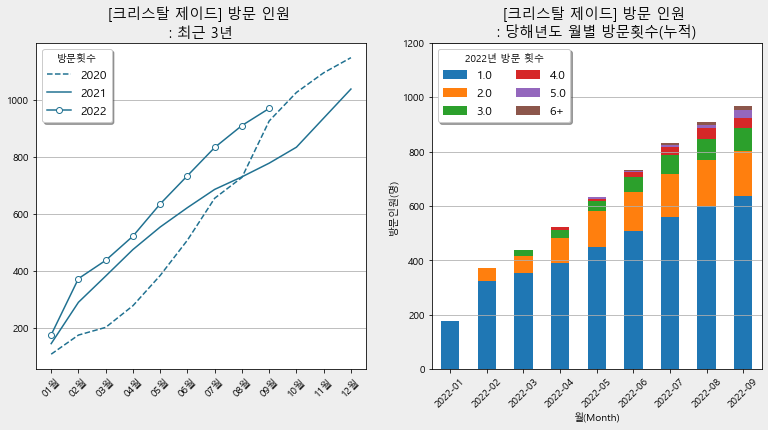

In [93]:
mpl.rc('figure', figsize=(13, 6), facecolor='#eeeeee')

ax1 = plt.subplot(1,2,1)
plt.plot(report_01[report_01.columns[0]], '--', color = '#207191', label=report_01.columns[0])
plt.plot(report_01[report_01.columns[1]], '-',  color = '#207191', label=report_01.columns[1])
plt.plot(report_01[report_01.columns[2]], color = '#207191', label=report_01.columns[2], marker= "o", markerfacecolor ='w')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.legend(loc='best', fancybox=True, shadow=True, ncol= 1, fontsize='large').set_title("방문횟수")
plt.title('[크리스탈 제이드] 방문 인원 \n: 최근 3년',fontsize='x-large')

ax2 = plt.subplot(1,2,2)
pd.crosstab(df1_vf.REG_DM, df1_vf.VISIT_COUNT, df1_vf.UNFY_MMB_NO, aggfunc="count").plot.bar(stacked=True, ax = ax2)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.24), fancybox=True, shadow=True, ncol=4).set_title("방문횟수(건)")
plt.legend(loc='upper left', fancybox=True, shadow=True, ncol= 2, fontsize='large').set_title("2022년 방문 횟수")
# plt.axvspan(10.5, 12.5, color='gray', alpha=0.3)
# plt.axvspan(12.5, 15.5, color='red', alpha=0.2)
plt.ylim(0, 1200)
plt.grid(True, axis='y')
plt.title('[크리스탈 제이드] 방문 인원 \n: 당해년도 월별 방문횟수(누적)',fontsize='x-large')
plt.xticks(rotation=45)
plt.xlabel('월(Month)')
plt.ylabel('방문인원(명)')

plt.show()


REG_DM
2022-01   175
2022-02   323
2022-03   353
2022-04   389
2022-05   450
2022-06   506
2022-07   558
2022-08   601
2022-09   637
Name: 1.0, dtype: float64

In [95]:
# 누적 방문자수 시각화
df_tt = pd.crosstab(df1_vf.REG_DM, df1_vf.VISIT_COUNT, df1_vf.UNFY_MMB_NO, aggfunc="count", margins= True, margins_name = 'Total(22Y)')[:-1]
df_tt = df_tt.fillna('')

report_02B = round((df_tt[df_tt.columns[-1]] - df_tt[df_tt.columns[0]]) / df_tt[df_tt.columns[-1]]*100,2)

In [103]:
Return_rate = report_02B[-1]

34.26

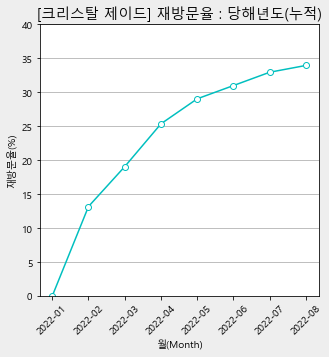

In [132]:
mpl.rc('figure', figsize=(5, 5), facecolor='#eeeeee')

plt.plot(report_02B, marker= "o", markerfacecolor ='w', color = 'blueviolet')
plt.grid(True, axis='y')
plt.ylim(0, 40)
plt.title('[크리스탈 제이드] 재방문율 : 당해년도(누적)',fontsize='x-large')
plt.xticks(rotation=45)
plt.xlabel('월(Month)')
plt.ylabel('재방문율(%)')
plt.show()

In [188]:
# df1_B.groupby('VISIT_COUNT').count().reset_index()

In [350]:
# 쿼리비교 : 월별 이용 기준
query1C ='''
select unfy_mmb_no, stor_no, REG_DM, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun) AS service
from (
    select T1.unfy_mmb_no, T1.stor_no, trunc(min(T1.reg_dtm)) as REG_DTM, to_char(min(T1.reg_dtm), 'YYYY-MM') as REG_DM, 'point_acml' AS gubun
    from TP_TRSC_PTCL T1 where T1.COOPCO_CD in('7050') and T1.ACML_PINT > 0 and to_char(T1.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    group by T1.unfy_mmb_no, T1.stor_no
    union all
    select T2.unfy_mmb_no, T2.stor_no, trunc(min(T2.reg_dtm)) as REG_DTM, to_char(min(T2.reg_dtm), 'YYYY-MM') as REG_DM,  'point_use' AS gubun
    from TP_TRSC_PTCL T2 where  T2.COOPCO_CD in ('7050') and T2.USE_PINT > 0 and to_char(T2.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    group by T2.unfy_mmb_no,T2.stor_no
    union all
    select A.unfy_mmb_no, U.stor_no, trunc(min(A.upd_dtm)) as REG_DTM, to_char(min(A.upd_dtm), 'YYYY-MM') as REG_DM,  'coupon' AS gubun
    from mmbship.TPM_CPN_ISSU A, TPM_CPN B, TPM_CPN_USE U
    where A.CPN_CD = B.cpn_cd and cpn_st_cd ='2'  and  A.cpn_issu_cd = U.cpn_issu_cd
    and B.use_coopco_cd in ('7050') and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    group by A.unfy_mmb_no, U.stor_no
    union all
    select M.unfy_mmb_no, U.stor_cd as stor_no,  trunc(min(U.REG_DT)) as REG_DTM, to_char(min(U.REG_DT), 'YYYY-MM') as REG_DM,  'gift_card' AS gubun
    from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
    where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
    group by M.unfy_mmb_no, U.stor_cd
)
GROUP BY unfy_mmb_no, stor_no, REG_DM
'''
df1_C =  pd.read_sql(query1C, con = conn )
df1_C['VISIT_COUNT'] = df1_C.groupby(['UNFY_MMB_NO', 'STOR_NO']).cumcount(ascending=True)+1
df1_C['CNT'] = 1

In [16]:
# df1_C[df1_C.STOR_NO=='1917030'][['UNFY_MMB_NO', 'REG_DM', 'SERVICE', 'VISIT_COUNT', 'STOR_NO']]

In [15]:
# df1_store 

In [376]:
store_list = list(df1_C.STOR_NO.unique())
df1_store  = pd.DataFrame()

for code in store_list:
    try:
        cumsum_count2 = df1_C[df1_C.STOR_NO==code].groupby('UNFY_MMB_NO' ).apply(lambda x: pd.Series(x['CNT'].count() ,index=x['REG_DM']))
        cumsum_count2 = cumsum_count2.unstack(level=1).fillna(method='ffill', axis=1)
        cumsum_count2 = cumsum_count2.unstack(level=0)
        df_temp2 = pd.DataFrame(cumsum_count2).reset_index()
        df1_store1 = pd.merge(df_temp2, df1_C, on =['UNFY_MMB_NO', 'REG_DM'], how = 'left').reset_index(drop=True)
        df1_store1.rename(columns = {0: 'CHECK'}, inplace = True)
        df1_store1 = df1_store1.sort_values(by=['UNFY_MMB_NO', 'REG_DM'], ascending=True).reset_index(drop=True)
        df1_store1 = df1_store1[df1_store1.CHECK >= 1.0].reset_index(drop=True)
        df1_store1['VISIT_COUNT']= df1_store1['VISIT_COUNT'].fillna(method='pad')
        df1_store1['SERVICE']= df1_store1['SERVICE'].fillna(method='pad')
        df1_store1 = df1_store1[['UNFY_MMB_NO', 'REG_DM', 'SERVICE', 'VISIT_COUNT']]
        df1_store1 = df1_store1.dropna().reset_index(drop=True)
        df1_store1['STOR_NO'] = code
    except: 
        pass
    df1_store = pd.concat([df1_store, df1_store1], ignore_index=True)

In [384]:
df1_storeA = pd.crosstab([df1_store.VISIT_COUNT,df1_store.STOR_NO, ],df1_store.REG_DM,  df1_store.UNFY_MMB_NO, aggfunc="count")
df1_storeA.fillna('')

REG_DM              2022-01 2022-02 2022-03 2022-04 2022-05 2022-06 2022-07  \
VISIT_COUNT STOR_NO                                                           
1.0         1917001    22.0    42.0    53.0    66.0    77.0    97.0   116.0   
            1917002    21.0    55.0    62.0    81.0    94.0    97.0   107.0   
            1917003     6.0    13.0    17.0    20.0            24.0    29.0   
            1917005    24.0    42.0    41.0    50.0    57.0    64.0    72.0   
            1917019     8.0    19.0    24.0    32.0    37.0    41.0    49.0   
            1917023    11.0    28.0    32.0    40.0    45.0    51.0    54.0   
            1917024    36.0    79.0    87.0   101.0   124.0   141.0   156.0   
            1917027    12.0    34.0    38.0    42.0    46.0    56.0    70.0   
            1917028    22.0    35.0    41.0    48.0    54.0    71.0    76.0   
            1917029    20.0    30.0    41.0    54.0    65.0    75.0    88.0   
            1917031     6.0    19.0    28.0    31.0    34.0    37.0    38.0   
            1917032                                    42.0    51.0    55.0   
2.0         1917001             1.0     2.0     3.0     2.0     2.0     6.0   
            1917002                             2.0     2.0     6.0     7.0   
            1917003                             1.0             2.0     2.0   
            1917005             2.0     6.0     6.0     6.0     6.0     7.0   
            1917019             1.0     1.0     2.0     3.0     4.0     2.0   
            1917023                             1.0     1.0             1.0   
            1917024             5.0    10.0    11.0    10.0    12.0    16.0   
            1917027             2.0     2.0     2.0     2.0     2.0     4.0   
            1917028             5.0     5.0     7.0     9.0    10.0    11.0   
            1917029             1.0     1.0     4.0     4.0     5.0     7.0   
            1917031             1.0                     1.0     1.0     1.0   
            1917032                                                           
3.0         1917001                                     1.0     1.0     1.0   
            1917019                                                     1.0   
            1917024                                     1.0     1.0     1.0   
            1917027                                                           
            1917028                                                     1.0   
            1917029                                                           

REG_DM               2022-08  
VISIT_COUNT STOR_NO           
1.0         1917001    125.0  
            1917002    113.0  
            1917003     31.0  
            1917005     81.0  
            1917019     54.0  
            1917023     59.0  
            1917024    156.0  
            1917027     76.0  
            1917028     78.0  
            1917029     91.0  
            1917031     42.0  
            1917032     60.0  
2.0         1917001      7.0  
            1917002      9.0  
            1917003      3.0  
            1917005      8.0  
            1917019      3.0  
            1917023      1.0  
            1917024     21.0  
            1917027      4.0  
            1917028     17.0  
            1917029      9.0  
            1917031      1.0  
            1917032      2.0  
3.0         1917001      1.0  
            1917019      2.0  
            1917024      1.0  
            1917027      2.0  
            1917028      1.0  
            1917029      1.0

In [379]:
df1_store.groupby([df1_store1.STOR_NO, df1_store1.REG_DM,  df1_store1.VISIT_COUNT ])['UNFY_MMB_NO'].count()

STOR_NO  REG_DM   VISIT_COUNT
1917027  2022-01  1.0             6
         2022-02  1.0            17
                  2.0             1
         2022-03  1.0            19
                  2.0             1
         2022-04  1.0            21
                  2.0             1
         2022-05  1.0            23
                  2.0             1
         2022-06  1.0            28
                  2.0             1
         2022-07  1.0            35
                  2.0             2
         2022-08  1.0            38
                  2.0             2
                  3.0             1
Name: UNFY_MMB_NO, dtype: int64

In [355]:
df1_store1 = pd.merge(df_temp2, df1_C, on =['UNFY_MMB_NO', 'REG_DM'], how = 'left').reset_index(drop=True)
df1_store1.rename(columns = {0: 'CHECK'}, inplace = True)

df1_store1 = df1_store1.sort_values(by=['UNFY_MMB_NO', 'REG_DM'], ascending=True).reset_index(drop=True)
df1_store1 = df1_store1[df1_store1.CHECK >= 1.0].reset_index(drop=True)

df1_store1['VISIT_COUNT']= df1_store1['VISIT_COUNT'].fillna(method='pad')
df1_store1['SERVICE']= df1_store1['SERVICE'].fillna(method='pad')

df1_store1 = df1_store1[['UNFY_MMB_NO', 'REG_DM', 'SERVICE', 'VISIT_COUNT']]

df1_store1 = df1_store1.dropna().reset_index(drop=True)

In [19]:

###############
# C.서비스 이용 인원 : venn
#####

# 쿼리비교 : 일별 이용 기준
query_service ='''
    select service, count(*) as CNT from(
    select unfy_mmb_no, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun ASC) OVER(PARTITION BY unfy_mmb_no) AS service
    from (
        select distinct unfy_mmb_no, (case when gubun like '%point_%' then 'point' else gubun end) as gubun
        from (
            select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, 'point_acml' AS gubun
            from TP_TRSC_PTCL
            where COOPCO_CD in('7050') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM,  'point_use' AS gubun
            from TP_TRSC_PTCL
            where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select distinct  A.unfy_mmb_no, trunc(A.upd_dtm) as REG_DTM, to_char(A.upd_dtm, 'YYYY-MM') as REG_DM,  'coupon' AS gubun
            from mmbship.TPM_CPN_ISSU A, TPM_CPN B
            where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            union all
            select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM,  'gift_card' AS gubun
            from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
            where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
        )
    )
    ) group by service
    '''
df_cross_by_service =  pd.read_sql(query_service, con = conn )

In [20]:
# df1_C

In [21]:
# 기준 테이블 생성
data = ['coupon', 'coupon,gift_card',  'coupon,gift_card,point', 'coupon,point', 'gift_card', 'gift_card,point', 'point']
df_cross_by_service_t = pd.DataFrame(data, columns=['SERVICE'])

# merge
df_cross_by_service =pd.merge(df_cross_by_service_t,df_cross_by_service, on = 'SERVICE', how ='left' ).fillna(0)

In [26]:
df_cross_by_service

,SERVICE,CNT
0,coupon,188
1,"coupon,gift_card",148
2,"coupon,gift_card,point",264
3,"coupon,point",118
4,gift_card,236
5,"gift_card,point",162
6,point,249


In [23]:
# 쿼리비교 : 관계사 교차이용 분석
query ='''
select BRAND, count(*) as CNT from(
select unfy_mmb_no, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun ASC) OVER(PARTITION BY unfy_mmb_no) AS BRAND
from (
    select distinct unfy_mmb_no,  gubun
    from (
        select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, COOPCO_CD AS gubun
        from TP_TRSC_PTCL
        where COOPCO_CD in('7050', '7060', '7030') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, COOPCO_CD AS gubun
        from TP_TRSC_PTCL
        where  COOPCO_CD in ('7050', '7060', '7030') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select distinct  A.unfy_mmb_no, trunc(A.upd_dtm) as REG_DTM, to_char(A.upd_dtm, 'YYYY-MM') as REG_DM, B.use_coopco_cd AS gubun
        from mmbship.TPM_CPN_ISSU A, TPM_CPN B
        where B.use_coopco_cd in ('7050', '7060', '7030') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM, U.coopco_cd AS gubun
        from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
        where U.coopco_cd in('7050', '7060', '7030') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
    )
)
) group by BRAND
'''
df_cross_by_brand =  pd.read_sql(query, con = conn )

In [24]:
df_cross_by_brand

,BRAND,CNT
0,7030,20989
1,"7030,7050",638
2,"7030,7050,7060",240
3,"7030,7060",112
4,7050,548
5,"7050,7060",56
6,7060,114


In [25]:
# 기준 테이블 생성
data = ['7030', '7030,7050',  '7030,7050,7060', '7030,7060', '7050', '7050,7060', '7060']
df_brand_t = pd.DataFrame(data, columns=['BRAND'])

# merge
df_brand =pd.merge(df_cross_by_brand,df_brand_t, on = 'BRAND', how ='left' ).fillna(0)

In [77]:
# Import the library
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)                               # 한글폰트 설정(전역)

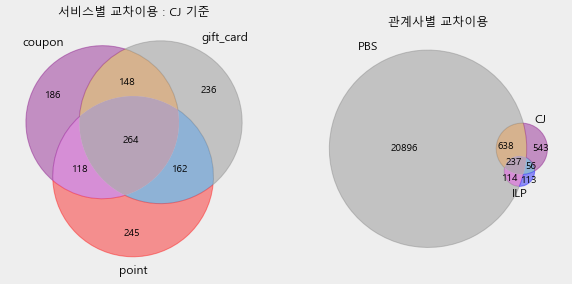

In [78]:
mpl.rc('figure', figsize=(10, 5), facecolor='#eeeeee')

ax2 = plt.subplot(1,2,1)
c= venn3(subsets = (df1_C[df1_C.SERVICE == 'coupon']['CNT'].values[0],
                    df1_C[df1_C.SERVICE == 'gift_card']['CNT'].values[0],
                    df1_C[df1_C.SERVICE == 'coupon,gift_card']['CNT'].values[0],
                    df1_C[df1_C.SERVICE == 'point']['CNT'].values[0],
                    df1_C[df1_C.SERVICE == 'coupon,point']['CNT'].values[0],
                    df1_C[df1_C.SERVICE == 'gift_card,point']['CNT'].values[0],
                    df1_C[df1_C.SERVICE == 'coupon,gift_card,point']['CNT'].values[0]), 
         set_labels = ('coupon', 'gift_card', 'point'))
c.get_patch_by_id('100').set_color('purple')
c.get_patch_by_id('010').set_color('gray')
c.get_patch_by_id('001').set_color('red')
plt.title('서비스별 교차이용 : CJ 기준')

ax2 = plt.subplot(1,2,2)
c= venn3(subsets = (df_brand[df_brand.BRAND == '7030']['CNT'].values[0],
                    df_brand[df_brand.BRAND == '7050']['CNT'].values[0],
                    df_brand[df_brand.BRAND == '7030,7050']['CNT'].values[0],
                    df_brand[df_brand.BRAND == '7060']['CNT'].values[0],
                    df_brand[df_brand.BRAND == '7030,7060']['CNT'].values[0],
                    df_brand[df_brand.BRAND == '7050,7060']['CNT'].values[0],
                    df_brand[df_brand.BRAND == '7030,7050,7060']['CNT'].values[0]), 
         set_labels = ('PBS', 'CJ', 'ILP'))
c.get_patch_by_id('100').set_color('gray')
c.get_patch_by_id('010').set_color('purple')
c.get_patch_by_id('001').set_color('blue')
plt.title('관계사별 교차이용')

plt.show()

In [47]:
# mpl.rc('figure', figsize=(5, 5), facecolor='#eeeeee')

# c= venn3(subsets = (df1_C[df1_C.SERVICE == 'coupon']['CNT'].values[0],
#                     df1_C[df1_C.SERVICE == 'gift_card']['CNT'].values[0],
#                     df1_C[df1_C.SERVICE == 'coupon,gift_card']['CNT'].values[0],
#                     df1_C[df1_C.SERVICE == 'point']['CNT'].values[0],
#                     df1_C[df1_C.SERVICE == 'coupon,point']['CNT'].values[0],
#                     df1_C[df1_C.SERVICE == 'gift_card,point']['CNT'].values[0],
#                     df1_C[df1_C.SERVICE == 'coupon,gift_card,point']['CNT'].values[0]), 
#          set_labels = ('coupon', 'gift_card', 'point'))
# c.get_patch_by_id('100').set_color('purple')
# c.get_patch_by_id('010').set_color('gray')
# c.get_patch_by_id('001').set_color('red')
# plt.show()

In [48]:
# mpl.rc('figure', figsize=(5, 5), facecolor='#eeeeee')

# ax1 = subplot(1,2,1)
# c= venn3(subsets = (df_brand[df_brand.BRAND == '7030']['CNT'].values[0],
#                     df_brand[df_brand.BRAND == '7050']['CNT'].values[0],
#                     df_brand[df_brand.BRAND == '7030,7050']['CNT'].values[0],
#                     df_brand[df_brand.BRAND == '7060']['CNT'].values[0],
#                     df_brand[df_brand.BRAND == '7030,7060']['CNT'].values[0],
#                     df_brand[df_brand.BRAND == '7050,7060']['CNT'].values[0],
#                     df_brand[df_brand.BRAND == '7030,7050,7060']['CNT'].values[0]), 
#          set_labels = ('PBS', 'CJ', 'ILP'))
# c.get_patch_by_id('100').set_color('gray')
# c.get_patch_by_id('010').set_color('purple')
# c.get_patch_by_id('001').set_color('blue')
# plt.show()

In [130]:
plt.savefig('image_name_test.png', bbox_inches='tight', dpi=70)

<Figure size 936x360 with 0 Axes>

In [147]:
###############
# D. RFM 분석
#####


query = '''
    with employee_list as 
        ( select distinct unfy_mmb_no, 'Y' as gubun
        from mmbship.tpr_crd_mstr
        where crd_kind = '998')

    --쿠폰 사용
    select I.unfy_mmb_no
    , '쿠폰 사용' as TRSC_TYP_CD , U.coopco_CD, U.dc_amt as USE_AMT, U.dc_tgt_amt as TOT_SEL_AMT, U.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.tpm_cpn_use U, mmbship.tpm_cpn_issu C, employee_list E, tm_mmb_info I
    where C.unfy_mmb_no = I.unfy_mmb_no 
    and C.unfy_mmb_no = E.unfy_mmb_no(+)
    and C.cpn_issu_cd = U.cpn_issu_cd
    and C.cpn_st_Cd = '2'
    and U.coopco_CD in ('7050', '7060') 
    and I.mmb_st_cd = '1'
    and C.unfy_mmb_no not in ('443986')
    and to_char(U.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    --and U.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -7 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )           
    union all
    --포인트 적립/사용
    select T.unfy_mmb_no
    , (select code_nm from mmbship.JT_CODE where code_grp_id = 'PM001' and trsc_typ_cd = code) as trsc_typ_cd
    , T.coopco_cd, (case when acml_pint = 0 then use_pint else acml_pint end) as use_amt , T.tot_sel_amt, T.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.TP_TRSC_PTCL T, employee_list E, tm_mmb_info I
    where T.unfy_mmb_no is not null 
    and T.tot_sel_amt > 0 
    and T.unfy_mmb_no = I.unfy_mmb_no 
    and I.mmb_st_cd = '1'
    and T.unfy_mmb_no = E.unfy_mmb_no(+)
    and to_char(T.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    --and T.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -7 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )
    and T.trsc_typ_cd in ( '200', '300')
    and T.COOPCO_CD in ('7050', '7060')
    union all
    --기프트카드사용
    select T.unfy_mmb_no
    , (select code_nm from mmbship.JT_CODE where code_grp_id = 'PM001' and trsc_typ_cd = code) as trsc_typ_cd
    , T.coopco_cd, H.use_amt, T.tot_sel_amt, T.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.TP_TRSC_PTCL T, employee_list E, mmbship.tm_mmb_info I, mmbship.tpr_crd_actv_amt_use_hist H
    where T.unfy_mmb_no is not null 
    and T.tot_sel_amt > 0 
    and H.use_idx = T.apv_no
    and T.unfy_mmb_no = I.unfy_mmb_no 
    and I.mmb_st_cd = '1'
    and T.unfy_mmb_no = E.unfy_mmb_no(+)
    and to_char(T.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    --and T.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -7 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )
    and T.trsc_typ_cd in ( 'G40')
    and T.COOPCO_CD in ('7050', '7060')
        '''
df_all = pd.read_sql(query, con = conn )
df_all['UNFY_MMB_NO'] = df_all['UNFY_MMB_NO'].astype(object)
# 임직원 제외
df_all = df_all[df_all['GUBUN']=='N'].reset_index(drop=True)

# 분석 대상 관계사 지정
df = df_all[df_all.COOPCO_CD =='7050'].reset_index(drop=True)


In [148]:
# rfm

In [155]:

query = '''
        select cpn_cd, unfy_mmb_no
        from tpm_cpn_issu
        where cpn_cd in ('CP220907001', 'CP220908001')
        and cpn_st_cd = '2'
        '''
df_cpn_user = pd.read_sql(query, con = conn )
df_cpn_user['UNFY_MMB_NO'] = df_cpn_user['UNFY_MMB_NO'].astype(object)

In [149]:
# RFM 계산
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
from lifetimes.utils import summary_data_from_transaction_data

In [150]:

# RFM 계산
period_end_date = (datetime.today()+ timedelta(days=-1))
rfm = df.groupby('UNFY_MMB_NO').agg({'REG_DTM': lambda date: (period_end_date - date.max()).days, # Recency calclation
                                     'UNFY_MMB_NO': lambda num: num.count(), # Frequency calculation
                                     'TOT_SEL_AMT': lambda TotalPrice: TotalPrice.sum()}) # Monetary calculation

rfm.columns = ['Recency', 'Frequency', 'Monetary'] # Changing column names

# Converting
rfm['recency_score']   = pd.qcut(rfm['Recency'], 5, [5, 4, 3, 2,1])
rfm['frequency_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, [1, 2, 3, 4, 5]) 
rfm['monetary_score']  = pd.qcut(rfm['Monetary'], 5, [1, 2, 3, 4, 5]) 

# Calculating RFM score
rfm['RFM_SCORE'] = (rfm['recency_score'].astype('str') + rfm['frequency_score'].astype('str'))

seg_map = {
    r'[1-2][1-2]': '10.hibernating', # For instance means: If F is 1 or 2 and If R is 1 or 2 give hibernating 
    r'[1-2]5': '09.cant_loose',
    r'[1-2][3-4]': '08.at_Risk',
    r'3[1-2]': '07.about_to_sleep',
    r'33': '06.need_attention',
    r'41': '05.promising',
    r'51': '04.new_customers',
    r'[4-5][2-3]': '03.potential_loyalists',
    r'[3-4][4-5]': '02.loyal_customers',
    r'5[4-5]': '01.champions'
}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm2 = pd.merge(rfm, df[['UNFY_MMB_NO', 'AGE']].drop_duplicates(), left_on='UNFY_MMB_NO', right_on='UNFY_MMB_NO', how='left')

summary = summary_data_from_transaction_data(df, 'UNFY_MMB_NO', 'REG_DTM', observation_period_end=df.REG_DTM.max().strftime('%Y-%m-%d'))
summary = summary.reset_index()
rfm_lifetime = rfm2[['UNFY_MMB_NO', 'segment']]

summary = pd.merge( summary, rfm_lifetime, on ='UNFY_MMB_NO', how ='left')


# 예측값 모델링

# BGF 모형 : 예상 방문 비율 추정
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
data = summary.copy()

t = 15
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
BGF_15t = list(data.groupby('segment')['predicted_purchases'].mean())

t = 30
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
BGF_30t = list(data.groupby('segment')['predicted_purchases'].mean())



# Gamma/Gamma 모형 : 예상 사용금액 추정
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm2['Frequency'], rfm2['Monetary'])

ggf.conditional_expected_average_profit(rfm2['Frequency'], rfm2['Monetary']).head(10)
ggf.conditional_expected_average_profit(rfm2['Frequency'], rfm2['Monetary']).sort_values(ascending=False).head(10)

rfm2["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm2['Frequency'],rfm2['Monetary'])


In [153]:
rfm2

,UNFY_MMB_NO,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,AGE,expected_average_profit
0,509909,93,1,63000,3,1,2,31,07.about_to_sleep,50,"100,329.7"
1,534776,18,4,975000,5,4,5,54,01.champions,50,"1,074,987.1"
2,624510,198,1,208000,1,1,4,11,10.hibernating,48,"331,238.8"
3,666052,71,4,261000,4,4,4,44,02.loyal_customers,48,"287,766.2"
4,693601,253,1,45000,1,1,1,11,10.hibernating,47,"71,665.1"
...,...,...,...,...,...,...,...,...,...,...,...
884,6628286,9,1,54500,5,3,2,53,03.potential_loyalists,55,"86,793.6"
885,6632548,3,3,243000,5,4,4,54,01.champions,33,"277,403.1"
886,6633758,2,1,38500,5,3,1,53,03.potential_loyalists,31,"61,314.0"
887,6633894,1,1,46000,5,3,2,53,03.potential_loyalists,46,"73,257.6"


In [156]:
df_cpn_user_vf = pd.merge(rfm2, df_cpn_user, on ='UNFY_MMB_NO', how= 'left')

In [161]:
df_cpn_user_vf[(df_cpn_user_vf.CPN_CD =='CP220907001')| (df_cpn_user_vf.CPN_CD =='CP220908001')]

,UNFY_MMB_NO,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,AGE,expected_average_profit,CPN_CD
10,818876,9,1,47000,5,1,2,51,04.new_customers,45,"74,850.0",CP220907001
14,930426,-1,14,658000,5,5,5,55,01.champions,51,"675,963.8",CP220908001
26,1132313,10,2,101000,5,3,3,53,03.potential_loyalists,38,"124,083.6",CP220907001
36,1234819,3,13,584000,5,5,5,55,01.champions,49,"601,206.1",CP220908001
101,3403569,11,13,496000,5,5,5,55,01.champions,39,"510,613.4",CP220908001
113,3538957,11,3,156000,5,4,4,54,01.champions,40,"178,086.3",CP220907001
127,3758441,3,1,47000,5,1,2,51,04.new_customers,44,"74,850.0",CP220907001
134,3895051,12,8,1260200,5,5,5,55,01.champions,40,"1,321,665.6",CP220908001
145,4083968,10,4,138000,5,4,4,54,01.champions,40,"152,152.6",CP220907001
166,4617111,1,3,164000,5,4,4,54,01.champions,37,"187,218.9",CP220907001


In [151]:
# 최종 결과 정리
report_04 = pd.pivot_table(rfm2, 
                         values=['Monetary',  'Frequency', 'expected_average_profit','AGE'], 
                         index=['segment'],  
                         aggfunc=np.mean).fillna(0)


report_04 = report_04.reset_index()
report_04['Monetary(Pred.)'] = report_04['expected_average_profit'] - report_04['Monetary']
report_04['Frequency(Pred.)'] = BGF_30t

report_04['COUNT'] = list(summary.groupby('segment')['T'].count())
report_04 = report_04[['segment','AGE','COUNT', 'Frequency', 'Monetary','Frequency(Pred.)', 'Monetary(Pred.)']]
pd.options.display.float_format = '{:0,.1f}'.format


In [152]:
# report_04['x'] = [5.0, 3.5, 4.5, 5.0, 4.0, 3.0, 3.0, 1.5, 1.5, 1.5,]
# report_04['y'] = [4.5, 4.5, 2.5, 1.0, 1.0, 3.0, 1.5, 3.5, 4.5, 1.5,]

In [ ]:
report_04

In [10]:
##########
# 자료저장(DataFrame to Excel)
#####

s_dt1= (datetime.today()- timedelta(0)).strftime('%Y%m%d')

excel_name = s_dt1 +'_report_CJ.xlsx'
writer = pd.ExcelWriter(excel_name)
rfm.to_excel(writer, '1.방문자수')
writer.save()   

writer.close()


In [13]:
rfm.groupby('segment')['RFM_SCORE'].count()

segment
01.champions              105
02.loyal_customers        150
03.potential_loyalists    119
04.new_customers           20
05.promising               19
06.need_attention          43
07.about_to_sleep          62
08.at_Risk                105
09.cant_loose              30
10.hibernating            205
Name: RFM_SCORE, dtype: int64

In [205]:
# fig = plt.gcf()
# ax = fig.add_subplot()
# fig.set_size_inches(16, 9)
# squarify.plot(sizes=report_04['COUNT'], 
#               label=list(report_04['segment']), alpha=.6 )
# plt.title("RFM Segments",fontsize=18,fontweight="bold")
# plt.axis('off')
# plt.show()

In [283]:
# fig = plt.figure(figsize=(8, 5))
# ax = plt.scatter(
#     x = report_04['x'], 
#     y = report_04['y'], 
#     s = report_04['COUNT']*10, 
#     alpha = 0.5, 
#     edgecolors = "gray" )

# plt.show()


### 2.프로모션 결과 : table

In [97]:

###############
# 3.데이터 불러오기 : Maeil Do 서비스별 매출기여 금액
#####


# 쿼리비교 : 단일합
query5B = '''select REG_YY, REG_MM, gubun
            , sum(누적방문자수) as CNT
            , sum(tot_sale_amt) as AMT
            from (select REG_YY, REG_MM, gubun, count(*) as 누적방문자수, sum(tot_sale_amt) as tot_sale_amt
                from (select unfy_mmb_no, REG_YY, gubun, max(REG_MM) as REG_MM, sum(tot_sale_amt) as tot_sale_amt
                    from (
                        select unfy_mmb_no, to_char(reg_dtm, 'YYYY') as REG_YY, to_char(reg_dtm, 'MM') as REG_MM, tot_sel_amt as tot_sale_amt, 'POINT_USE' as gubun
                        from TP_TRSC_PTCL
                        where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
                        union all
                        select A.unfy_mmb_no, to_char(A.upd_dtm, 'YYYY') as REG_YY, to_char(A.upd_dtm, 'MM') as REG_MM, T.tot_sel_amt as tot_sale_amt, 'COUPON' as gubun
                        from mmbship.TPM_CPN_ISSU A, TPM_CPN B, TP_TRSC_PTCL T, tpm_cpn_use U 
                        where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY') and U.apv_no = T.apv_no and T.trsc_typ_cd = '600' and U.cpn_issu_cd = A.cpn_issu_Cd
                        union all
                        select M.unfy_mmb_no, to_char(U.REG_DT, 'YYYY') as REG_YY, to_char(U.REG_DT, 'MM') as REG_MM, U.use_amt as tot_sale_amt, 'gift-CARD' as gubun
                        from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
                        where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
                        )
                    group by unfy_mmb_no, REG_YY, gubun
                    )
                group by REG_YY, REG_MM, gubun
                )
            group by REG_YY, REG_MM, gubun'''
df5B =  pd.read_sql(query5B, con = conn )


In [98]:
df5B['REG_MM'] = df5B['REG_MM'] + '월'

report_02 = pd.pivot_table(df5B, values='AMT', index=['REG_MM'],columns=['GUBUN'],  aggfunc='sum')

In [99]:
report_02.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 01월 to 09월
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   COUPON     9 non-null      int64
 1   POINT_USE  9 non-null      int64
 2   gift-CARD  9 non-null      int64
dtypes: int64(3)
memory usage: 288.0+ bytes


In [100]:
report_02

GUBUN,COUPON,POINT_USE,gift-CARD
REG_MM,,,
01월,1877600,560900,2400095
02월,7657800,1340100,3490632
03월,1524800,801000,2093260
04월,2970500,754000,4126350
05월,4145800,1359800,7064990
06월,3560700,544300,6124680
07월,5774100,2765100,7585645
08월,3643980,1760000,7895418
09월,8201100,2141500,11850775


<Figure size 432x432 with 0 Axes>

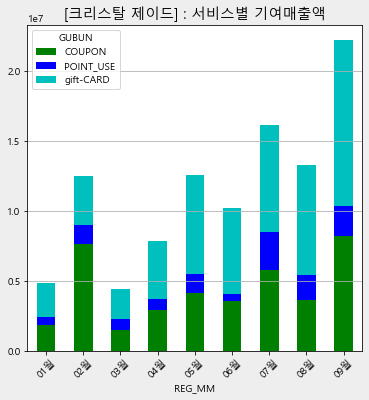

In [101]:
mpl.rc('figure', figsize=(6, 6))
fig = plt.figure()
colors = ['g', 'b',  'c']

report_02.plot(kind='bar', stacked=True, figsize=(6, 6), color=colors)
plt.title('[크리스탈 제이드] : 서비스별 기여매출액',fontsize='x-large')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
# image save
# date2 = datetime.today().strftime('%Y%m%d')
# image_name = date2[2:] +'_AMT_report_CJ.png'
# plt.savefig(image_name, bbox_inches='tight', dpi=70)

plt.show()

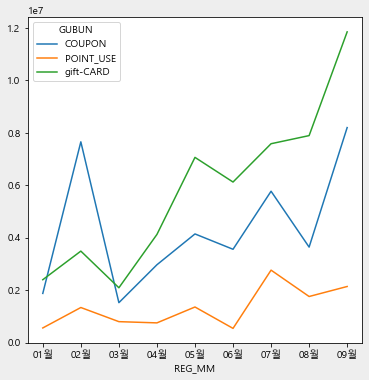

In [102]:
report_02.plot()

In [ ]:
'''
select distinct unfy_mmb_no, REG_DM
--, LISTAGG(gubun,', ' ON OVERFLOW TRUNCATE WITH COUNT)  WITHIN GROUP (ORDER BY job)
--, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun) AS service
, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun ASC) OVER(PARTITION BY unfy_mmb_no, REG_DM) AS names
from (
    select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, 'point_acml' AS gubun
    from TP_TRSC_PTCL
    where COOPCO_CD in('7050') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM,  'point_use' AS gubun
    from TP_TRSC_PTCL
    where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select distinct  A.unfy_mmb_no, trunc(A.reg_dtm) as REG_DTM, to_char(A.reg_dtm, 'YYYY-MM') as REG_DM,  'coupon' AS gubun
    from mmbship.TPM_CPN_ISSU A, TPM_CPN B
    where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    union all
    select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM,  'gift_card' AS gubun
    from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
    where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
)
--GROUP BY unfy_mmb_no, REG_DM
;


 
 
select service, count(*) as CNT from(
select unfy_mmb_no, LISTAGG(gubun, ',') WITHIN GROUP(ORDER BY gubun ASC) OVER(PARTITION BY unfy_mmb_no) AS service
from (
    select distinct unfy_mmb_no, (case when gubun like '%point_%' then 'point' else gubun end) as gubun
    from (
        select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM, 'point_acml' AS gubun
        from TP_TRSC_PTCL
        where COOPCO_CD in('7050') and ACML_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select distinct unfy_mmb_no, trunc(reg_dtm) as REG_DTM, to_char(reg_dtm, 'YYYY-MM') as REG_DM,  'point_use' AS gubun
        from TP_TRSC_PTCL
        where  COOPCO_CD in ('7050') and USE_PINT > 0 and to_char(reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select distinct  A.unfy_mmb_no, trunc(A.reg_dtm) as REG_DTM, to_char(A.reg_dtm, 'YYYY-MM') as REG_DM,  'coupon' AS gubun
        from mmbship.TPM_CPN_ISSU A, TPM_CPN B
        where B.use_coopco_cd in ('7050') and A.CPN_CD = B.cpn_cd and cpn_st_cd ='2' and to_char(A.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
        union all
        select M.unfy_mmb_no, trunc(U.REG_DT) as REG_DTM, to_char(U.REG_DT, 'YYYY-MM') as REG_DM,  'gift_card' AS gubun
        from TPR_CRD_MSTR M, TPR_CRD_ACTV_AMT_USE_HIST U
        where U.coopco_cd in('7050') and M.crd_id = U.crd_id and M.UNFY_MMB_NO is not null and to_char(U.REG_DT, 'YYYY') = to_char(sysdate, 'YYYY') and U.use_amt > 0
    )
)
) group by service
;



/* 회원가입 : 외식사 공통 ? */ 
select  reg_dtm, count(*) from (
select to_char(reg_dtm, 'YYYY-MM' ) as reg_dtm
from tm_mmb_info
where ntry_coopco_cd = '7050'
and to_char(reg_dtm, 'YYYY' ) =  to_char(sysdate, 'YYYY' )
union all
select  to_char(reg_dtm, 'YYYY-MM' ) as reg_dtm
from tm_mmb_info
where ntry_coopco_cd = '7000'
and to_char(reg_dtm, 'YYYY' ) =  to_char(sysdate, 'YYYY' )
and ntry_chnl_cd = '42'
)
group by reg_dtm
;

/* 이벤트별 반응 : 외식 브랜드 */
select T.evnt_tite, T.evnt_no, T.evnt_str_dt, T.evnt_end_dt, count(g.unfy_mmb_no) as click_cnt
from tch_evnt_click_log g, tch_evnt T
where G.evnt_no = T.evnt_no
and (T.evnt_tite like '%크리스탈%' or T.evnt_tite like '%시즌메뉴%' or T.evnt_tite like '%기프트카드%')
and T.evnt_tite not like '%사전홍보%'
and substr(T.evnt_str_dt,1,4) = to_char(sysdate, 'YYYY')
group by  T.evnt_tite,  T.evnt_no, T.evnt_str_dt, T.evnt_end_dt
union all
select T.evnt_tite, T.evnt_no, T.evnt_str_dt, T.evnt_end_dt, count(g.unfy_mmb_no) as click_cnt
from tch_evnt_click_log g, tch_evnt T
where G.evnt_no = T.evnt_no
and (T.evnt_tite like '%일뽀르노%' or T.evnt_tite like '%발렌타인%')
and substr(T.evnt_str_dt,1,4) = to_char(sysdate, 'YYYY')
group by  T.evnt_tite,  T.evnt_no, T.evnt_str_dt, T.evnt_end_dt
;

/* 월별+이벤트별 반응 : CJ */
select to_char(g.reg_dtm, 'YYYY-MM') as reg_dtm , count(*)
from tch_evnt_click_log g, tch_evnt T
where G.evnt_no = T.evnt_no
and (T.evnt_tite like '%크리스탈%' or T.evnt_tite like '%시즌메뉴%' or T.evnt_tite like '%기프트카드%')
and T.evnt_tite not like '%사전홍보%'
and to_char(g.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
group by to_char(g.reg_dtm, 'YYYY-MM')
;

select T.* 
from tch_evnt T
where(T.evnt_tite like '%크리스탈%' or T.evnt_tite like '%시즌메뉴%' or T.evnt_tite like '%기프트카드%' )
and T.evnt_tite not like '%사전홍보%'
and to_char(T.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
;
'''

In [162]:

###############
# 2.데이터 불러오기 : 프로모션 결과
#####
query = '''
    select M.CPN_CD   AS 쿠폰코드
    , (case when M.USE_COOPCO_CD=7060 then 'ILP' when M.USE_COOPCO_CD=7050 then 'CYK' else 'PBS' end )AS 관계사
    --, (select code_nm from JT_CODE  where code_grp_id = 'CM041' and M.OFFR_TYP_CD=code)   AS 쿠폰유형
    , M.CPN_NM        AS 쿠폰이름
    , M.APCL_STR_DT   AS 시작일자
    --, substr(M.APCL_STR_DT,1,6)   AS 시작일자_구분
    , M.APCL_END_DT   AS 종료일자
    , (case when M.APCL_END_DT > to_char(sysdate-1, 'YYYYMMDD') then '진행중' else '종료' end) as "진행여부"
    , nvl(D1.click_cnt, D2.click_cnt) as "베너클릭(명)"
    , A.발급인원 as "발급인원(명)"
    , B.사용인원 as "사용인원(명)"
    , round(B.사용인원/A.발급인원,4)*100 as "사용율(발급대비,%)" 
    , (case when c.first_user_cnt is null then 0 else c.first_user_cnt end)as "사용인원_첫구매(명)"
    , B.사용인원 - (case when c.first_user_cnt is null then 0 else c.first_user_cnt end) as "사용인원_재구매(명)"
    , B.총결제금액 as "총결제금액(원)"
    , B.할인금액 as "할인금액(원)"
    --, B.사용일자 as "최종사용일"
    from mmbship.TPM_CPN M

      --A. 다운로드 인원*
      left join (select cpn_cd
      , count(*) as 발급인원
      from mmbship.TPM_CPN_ISSU
      where unfy_mmb_no is not null
      group by cpn_cd
      ) A
      on M.cpn_cd = A.cpn_cd

      --B. 사용 및 할인 금액
      left join (select I.cpn_cd
      , count(I.unfy_mmb_no) as 사용인원
       , sum(P.tot_sel_amt) as 총결제금액
       , sum(U.DC_AMT) as 할인금액
       , max(U.apv_dt) as 사용일자
       from mmbship.TPM_CPN_use U, mmbship.TPM_CPN_ISSU I, tp_trsc_ptcl P
       where I.CPN_ISSU_CD = U.CPN_ISSU_CD
       and P.apv_no = U.apv_no
       and I.cpn_st_cd ='2'
       and U.can_apv_dt is null
       group by I.cpn_cd
      ) B
      on M.cpn_cd = B.cpn_cd

      --C.당해년도 첫구매/재구매 인원
      left join (
        with cpn_user as (
            select unfy_mmb_no, min(use_dtm) as use_dtm from (
            select I.unfy_mmb_no, I.cpn_cd, trunc(I.upd_dtm) as use_dtm
            from tpm_cpn_issu I , tpm_cpn C 
            where I.cpn_st_cd = '2'
            and I.cpn_cd = C.cpn_Cd
            and I.cpn_Cd not like 'PBS%'
            and C.use_coopco_Cd = 7050
            and to_char(C.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            and to_char(I.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            ) group by unfy_mmb_no),
        cpn_cd_user as (
            select I.unfy_mmb_no, I.cpn_cd,  C.use_coopco_Cd, trunc(I.upd_dtm) as use_dtm
            from tpm_cpn_issu I , tpm_cpn C 
            where I.cpn_st_cd = '2'
            and I.cpn_cd = C.cpn_Cd
            and I.cpn_Cd not like 'PBS%'
            and C.use_coopco_Cd = 7050
            and to_char(C.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
            and to_char(I.upd_dtm, 'YYYY') = to_char(sysdate, 'YYYY') )
        select  A.cpn_Cd, A.use_coopco_Cd, count(*) as first_user_cnt
        from cpn_user U, cpn_cd_user A
        where a.unfy_mmb_no = U.unfy_mmb_no
        and A.use_dtm = U.use_dtm
        group by A.cpn_Cd, A.use_coopco_Cd
      ) C
      on M.cpn_cd = C.cpn_cd


      --D1. 일뽀르노 베너클릭 인원 
      left join (select T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt, count(g.unfy_mmb_no) as click_cnt
            from tch_evnt_click_log g, tch_evnt T
            where G.evnt_no = T.evnt_no
            and T.evnt_tite like '%일뽀르노%' or T.evnt_tite like '%발렌%'
            group by  T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt
      ) D1
      on D1.evnt_str_dt = M.APCL_STR_DT
      and D1.evnt_end_dt = M.APCL_END_DT
      and  M.USE_COOPCO_CD=7060

      --D2. 크리스탈 제이드 베너클릭 인원 
      left join (
            select T.evnt_no, T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt, count(g.unfy_mmb_no) as click_cnt
            from tch_evnt_click_log g, tch_evnt T
            where G.evnt_no = T.evnt_no
            and T.evnt_tite like '%크리스탈%' 
            group by  T.evnt_no, T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt
            union all
            select T.evnt_no, T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt, count(g.unfy_mmb_no) as click_cnt
            from tch_evnt_click_log g, tch_evnt T
            where G.evnt_no = T.evnt_no
            and T.evnt_tite like '%시즌메뉴%' 
            group by  T.evnt_no, T.evnt_tite, T.evnt_str_dt, T.evnt_end_dt
      ) D2
      on D2.evnt_str_dt = M.APCL_STR_DT
      and D2.evnt_end_dt = M.APCL_END_DT
      and M.USE_COOPCO_CD=7050

    where M.USE_YN ='Y'
    --AND M.CUR_ISSU_QNT IS NOT NULL
    and M.APCL_END_DT not in (29991231, 99991231, 20170807, 20171203, 20171209)
    ORDER BY M.APCL_STR_DT, M.CPN_CD
'''

df = pd.read_sql(query, con = conn )


In [163]:
df['시작일자'] = pd.to_datetime(df['시작일자'],format = '%Y-%m-%d')
df['종료일자'] = pd.to_datetime(df['종료일자'],format = '%Y-%m-%d')

# df = df.astype({'발급인원(명)':'int',  '사용인원(명)':'int',  '사용인원_첫구매(명)':'int',  '사용인원_재구매(명)':'int',  '총결제금액(원)':'int', '할인금액(원)':'int'}) 
report_03 = df[(df['시작일자'] >= '20220101' )&(df['관계사'] == 'CYK') ].reset_index(drop=True).fillna('')

In [165]:
report_03

,쿠폰코드,관계사,쿠폰이름,시작일자,종료일자,진행여부,베너클릭(명),발급인원(명),사용인원(명),"사용율(발급대비,%)",사용인원_첫구매(명),사용인원_재구매(명),총결제금액(원),할인금액(원)
0,CP220210001,CYK,[Maeil Do!] 2022 발렌타인데이 이벤트 쿠폰,2022-02-11,2022-02-20,종료,,330.0,130.0,39.4,130,0.0,"8,179,400.0","2,600,000.0"
1,CP220304001,CYK,[Maeil Do] 봄 시즌메뉴 프로모션 2+1,2022-03-09,2022-04-30,종료,"3,047.0",731.0,93.0,12.7,64,29.0,"6,081,000.0","1,395,000.0"
2,CP220426001,CYK,[Maeil Do!] 크리스탈 제이드 천호점 추가쿠폰,2022-04-26,2022-05-31,종료,,37.0,3.0,8.1,0,3.0,"153,000.0","30,000.0"
3,CP220425001,CYK,[Maeil Do!] 크리스탈 제이드 천호점 오픈이벤트,2022-04-29,2022-05-31,종료,692.0,260.0,38.0,14.6,32,6.0,"1,249,700.0","247,000.0"
4,CP220512001,CYK,[Maeil Do!] 여름 시즌메뉴 프로모션 2+1,2022-05-13,2022-08-31,종료,"4,160.0",946.0,159.0,16.8,100,59.0,"11,713,000.0","2,385,000.0"
5,CP220907001,CYK,[Maeil Do!] 가을 시즌메뉴 프로모션 2+1,2022-09-13,2022-11-06,진행중,888.0,380.0,28.0,7.4,20,8.0,"2,170,900.0","448,000.0"
6,CP220908001,CYK,[Maeil Do!] 가을 시즌메뉴 VIP 쿠폰,2022-09-13,2022-10-12,진행중,,135.0,30.0,22.2,11,19.0,"2,168,000.0","900,000.0"
7,CP220927001,CYK,[Maeil Do!] 크리스탈 제이드 신규매장 오픈,2022-09-29,2022-10-30,진행중,,,,,0,,,


### Referal 자료 : 리뷰/블로그 건 수

In [19]:
# import
from google.cloud import bigquery
import os 

In [20]:
# import
from google.cloud import bigquery
import os 


###############
# 저장된 자료 불러오기
#####

# 접속 정보 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:/Users/MAEIL/OneDrive - 매일유업/auto_send/boxwood-chassis-356100-a2ec31483acb.json"
client = bigquery.Client()

#########
# 자료1 : 키워드 수집현황
###
sql1 = """
        select STORE_NAME, DATE as REG_DTM
        , sum(REVIEW_CNT) as REVIEW_CNT
        , sum(BLOG_CNT)   as BLOG_CNT
        , round(sum(REVIEW_SCORE*REVIEW_CNT) / sum(REVIEW_CNT),2) as REVIEW_SCORE_AVG
        from (
          SELECT (case when STORE_NAME like '크리스탈%' then '크리스탈 제이드' else '더 키친 일뽀르노' end) as STORE_NAME
          , FORMAT_DATETIME('%Y-%m-%d', CAST( TIMESTAMP_ADD(REG_DTM, INTERVAL -1 DAY) AS DATETIME)) as DATE
          , REVIEW_CNT
          , BLOG_CNT
          , REVIEW_SCORE
          FROM `boxwood-chassis-356100.review.dinning_review_summary` 
          where FORMAT_DATETIME('%Y', CAST(REG_DTM AS DATETIME)) =  FORMAT_DATETIME('%Y', current_date())
          )
        group by STORE_NAME, DATE
      """
df1 = client.query(sql1).to_dataframe()


In [21]:
df1

,STORE_NAME,DATE,REVIEW_CNT,BLOG_CNT,REVIEW_SCORE_AVG
0,크리스탈 제이드,2022-08-31,8356,3737,4.26
1,더 키친 일뽀르노,2022-08-31,1517,468,4.28


In [25]:
#########
# 자료1 : 키워드 수집현황
###
sql1 = """
          SELECT (case when STORE_NAME like '크리스탈%' then '크리스탈 제이드' else '더 키친 일뽀르노' end) as STORE_NAME
          , REVIEW_SCORE, REVIEW_CNT, BLOG_CNT
          , FORMAT_DATETIME('%Y-%m-%d', CAST( TIMESTAMP_ADD(REG_DTM, INTERVAL -1 DAY) AS DATETIME)) as DATE
          FROM `boxwood-chassis-356100.review.dinning_review_summary` 
          where FORMAT_DATETIME('%Y', CAST(REG_DTM AS DATETIME)) =  FORMAT_DATETIME('%Y', current_date())
      """
df02 = client.query(sql1).to_dataframe()

In [19]:
df02 = df02[df02.REVIEW_SCORE >= 0.01]
df02.tail(2)

,STORE_NAME,REVIEW_SCORE,REVIEW_CNT,BLOG_CNT,DATE
17,더 키친 일뽀르노,4.26,220,65,2022-08
18,더 키친 일뽀르노,4.18,247,84,2022-08


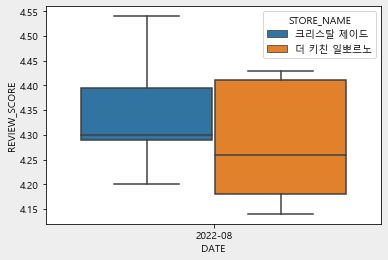

In [20]:
import seaborn as sns

mpl.rc('figure', figsize=(6, 4), facecolor='#eeeeee' )
sns.boxplot(x="DATE", y="REVIEW_SCORE", hue="STORE_NAME",  data=df02)
# plt.ylim(4, 5)
# plt.title("요일 별 전체 팁의 Box Plot")
plt.show()

In [67]:
# 평점 가중평균
grouped = df02.groupby(['STORE_NAME', 'DATE'])
weighted_avg_func = lambda g:np.average(g['REVIEW_SCORE'], weights=g['REVIEW_CNT'])
grouped.apply(weighted_avg_func)

STORE_NAME  DATE   
더 키친 일뽀르노   2022-08   4
크리스탈 제이드    2022-08   4
dtype: float64

In [82]:
result_04 = pd.DataFrame(grouped.apply(weighted_avg_func)).reset_index()
result_04.rename(columns = {0: 'REVIEW_SCORE(Avg.)'}, inplace = True)
pd.options.display.float_format = '{:0,.2f}'.format

In [83]:
result_04.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STORE_NAME          2 non-null      object 
 1   DATE                2 non-null      object 
 2   REVIEW_SCORE(Avg.)  2 non-null      float64
dtypes: float64(1), object(2)
memory usage: 176.0+ bytes


In [84]:
result_04

,STORE_NAME,DATE,REVIEW_SCORE(Avg.)
0,더 키친 일뽀르노,2022-08,4.31
1,크리스탈 제이드,2022-08,4.33


In [ ]:
/* App 신규 로그인 */
select trunc(A.reg_dtm), count(*)
from tch_app_device_info A
where A.reg_dtm between sysdate-45 and sysdate
group by trunc(A.reg_dtm)
;


/* App 신규 로그인 & 당일회원 가입*/
select trunc(A.reg_dtm), count(*)
from tch_app_device_info A, tm_mmb_info I
where A.reg_dtm between sysdate-90 and sysdate
and trunc(A.reg_dtm) = trunc(I.reg_dtm)
and I.unfy_mmb_no = A.unfy_mmbno
group by trunc(A.reg_dtm)
;

/* 월별 이용자 수(DAU) */
select to_char(reg_dtm, 'YYYYMM') as reg_dtm, sum(cnt)
from (
select trunc(A.reg_dtm) as reg_dtm, count(*) as cnt
from tch_app_device_info A
where to_char(A.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
group by trunc(A.reg_dtm)
) group by to_char(reg_dtm, 'YYYYMM')
;

/* 월별 시간별 접속인원 */
select reg_dtm,reg_HR, count(*) from (
select to_char(A.reg_dtm, 'YYYYMM') as reg_dtm
, to_char(A.reg_dtm, 'HH24') as reg_HR
from tch_app_device_info A
where to_char(A.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
order by reg_dtm desc
) group by reg_dtm, reg_HR
;



/* App 신규 로그인 & 당일회원 가입*/
select trunc(A.reg_dtm), count(*)
from tch_app_device_info A, tm_mmb_info I
where A.reg_dtm between sysdate-45 and sysdate
and trunc(A.reg_dtm) = trunc(I.reg_dtm)
and I.unfy_mmb_no = A.unfy_mmbno
group by trunc(A.reg_dtm)
;

In [ ]:
##########
# 자료저장(DataFrame to Excel)
#####

s_dt1= (datetime.today()- timedelta(0)).strftime('%Y%m%d')

excel_name = s_dt1 +'_report_CJ.xlsx'
writer = pd.ExcelWriter(excel_name)
report_01.to_excel(writer, '1.방문자수')
report_02.to_excel(writer, '2.기여매출_서비스별')
report_03.to_excel(writer, '3.쿠폰현황')
writer.save()   

writer.close()



In [ ]:

# 이미지파일 정렬
from glob import glob
import os 
path = ''
list_of_images = glob(os.path.join(path, "*_report_CJ.png") )
    

In [ ]:
###############
# 3.이메일 발송
#####

# 이메일 양식(내용) frame 구성하기
# 이메일 양식(내용) frame 구성하기
message_tmpl="""
<html>
    <!DOCTYPE html>
    <html>
    <head lang ="ko">
      <meta charset ="UTF-8">
      <title>{{title1}}</title>
    </head>
    <style type="text/css">
        table {
            border-collapse: collapse;
            font-size: 9pt;
            font-family: Malgun Gothic
            }  
        thead tr {
            background-color: #207191;
            color: #ffffff;
            }
    </STYLE>
    <BODY style="FONT-SIZE: 10pt; font-family: 맑은 고딕, Malgun Gothic, dotum, gulim, sans-serif">
        안녕하세요,<br>
        <br>
        {{send_date}}일 기준, 더키친 일뽀르노를 방문한 Maeil Do 회원내용 공유드립니다.<br>
        <br>
        <ol type="1">
        <li><b>{{title1}}</b></li>
        <li><b>{{title2}}</b></li>
        <table width="670" border="1" cellspacing="0" cellpadding="0">
        <tbody>
          <tr>
            <td style="width="65%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Graph</b></p></td>
            <td style="width="35%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Data</b></p></td>
          </tr>
          <tr>
            <td style="width="65%"; text-align: center;"><p style="text-align: center;"><img src="cid:{{image_file1}}"></p></td>
            <td style="width="35%"; text-align: center;"><p style="text-align: center;">{{ df1_html }}</p></td>
          </tr>
        </tbody>
        </table>
        <br>
        <b>2. 월별 매출기여 금액 : 서비스별 분류 </b><br>
        <table width="770" border="1" cellspacing="0" cellpadding="0">
        <tbody>
          <tr>
            <td style="width="65%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Graph</b></p></td>
            <td style="width="35%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Data</b></p></td>
          </tr>
          <tr>
            <td style="width="65%"; text-align: center;"><p style="text-align: center;"><img src="cid:{{image_file2}}"></p></td>
            <td style="width="35%"; text-align: center;"><p style="text-align: center;">{{ df2_html }}</p></td>
          </tr>
        </tbody>
        </table>
        <br>
        <li><b>{{title3}}</b></li>
            <ol type="A">
            <li>{{title3_A}}</li><br>
            <table width="770" border="1" cellspacing="0" cellpadding="0">
            <tbody>
              <tr>
                <td style="width="65%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Graph</b></p></td>
                <td style="width="35%"; text-align: center;" bgcolor="#84bbd1" ><p style="text-align: center;"><b>Data</b></p></td>
              </tr>
              <tr>
                <td style="width="65%"; text-align: center;"><p style="text-align: center;"><img src="cid:{{REPORT03_IMG}}"></p></td>
                <td style="width="35%"; text-align: center;"><p style="text-align: center;">{{ REPORT03_TAB }}</p></td>
              </tr>
            </tbody>
            </table>
            <li>{{title3_B}}</li><br>
            <img src="cid:{{image6}}"><br>
            </ol><br>
        <br>
        <li><b>{{title4}}</b></li>
        <p>{{ df4_html }}</p>
        <br>
        <자료 해석 예시><br>
        - {{text1}}<br>
        - {{text2}}<br>
        <br>
        - {{text3}}<br>
        - {{text4}}<br>
        <br>
        <SPAN style="COLOR: #808080">{{add_text1}}</SPAN><br>
        <SPAN style="COLOR: #808080">{{add_text2}}</SPAN><br>
        <br>
        <br>
        감사합니다.<br>
        <br>
    </BODY>
</html>"""

# 이메일 양식(내용) 변동 내용 정의
render_data = {
    'send_date'   : (datetime.today()- timedelta(days = 0)).strftime('%Y-%m-%d')[:7],
    'title1'      : '주요실적',
    'title1_A'    : '누적 방문자 수',
    'title1_B'    : '회원유발 매출액',
    'title1_C'    : '프로모션 ROAS',
    'title2'      : '회원 방문 분석',
    'title2_A'    : '누적 방문자 수',
    'title2_B'    : '회원유발 매출액',
    'title2_C'    : '프로모션 ROAS',
    'title3'      : '회원 매출 분석',
    'title3_A'    : '누적 방문자 수',
    'REPORT03_IMG': report_03.to_html(index = False),
    'REPORT03_TAB': report_03.to_html(index = False),
    'title3_B'    : '월별 서비스별 기여매출 금액',
    'title4'      : '서비스 이용 인원',
    'image_file1' : list_of_images[1],
    'image_file2' : list_of_images[0],
    'df1_html'    : report_01.to_html(index = True),
    'df2_html'    : report_02.to_html(index = True),
    'add_text1'   : "*  본 메일은 발신전용입니다.",
    'add_text2'   : "** (내용/기술문의 : 고객정보전략담당, 박경하 )"
}

t= Template(message_tmpl)
html_report = t.render(render_data)

In [ ]:
#########
# 발송 변수 설정
###

# 받는사람 : mulit 발송
to_users = ['a@maeil.com', 'b@maeil.com', 'c@maeil.com' ]

# 메일제목
subject = "[크리스탈 제이드] 월별 외식 회원활동 결과(발송전용)_v1.1"

# 본문
html = html_report

# 첨부파일 추가
try:
    attach = excel_name
except:
    attach  = None

# 이미지 추가
try:
    graph  = list_of_images
except:
    graph  = None

# 이메일 발송
se.send_email(to_users, subject, html,  graph, attach)